In [1]:

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Importing data realquick 

In [2]:
path = glob("../car-plate/images/*.xml") # '../code/car-plate/images/*.xml'
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [3]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df

,filepath,xmin,xmax,ymin,ymax
0,../car-plate/images\N1.xml,1093,1396,645,727
1,../car-plate/images\N100.xml,134,301,312,350
2,../car-plate/images\N101.xml,31,139,128,161
3,../car-plate/images\N102.xml,164,316,216,243
4,../car-plate/images\N103.xml,813,1067,665,724
...,...,...,...,...,...
220,../car-plate/images\N95.xml,23,408,173,391
221,../car-plate/images\N96.xml,137,352,141,186
222,../car-plate/images\N97.xml,175,290,228,255
223,../car-plate/images\N98.xml,563,675,207,238


In [4]:
filename = df['filepath'][0]

def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../car-plate/images',filename_image)
    return filepath_image
getFilename(filename)

'../car-plate/images\\N1.jpeg'

In [5]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['../car-plate/images\\N1.jpeg',
 '../car-plate/images\\N100.jpeg',
 '../car-plate/images\\N101.jpeg',
 '../car-plate/images\\N102.jpeg',
 '../car-plate/images\\N103.jpeg',
 '../car-plate/images\\N104.jpeg',
 '../car-plate/images\\N105.jpeg',
 '../car-plate/images\\N106.jpeg',
 '../car-plate/images\\N107.jpeg',
 '../car-plate/images\\N108.jpeg']

<p id="part11"></p>

# <span style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color:rgb(0, 0, 0); line-height:1.0">3. DATA PROCESSING</span>

<p id="part12"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color:rgb(0, 0, 0); line-height:1.0">3.1 READ DATA</span>

This is one of the most important part, in this process we will take each and every image and process it for it to be fed into the model 


In [6]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

here is diagram that explains the process visually

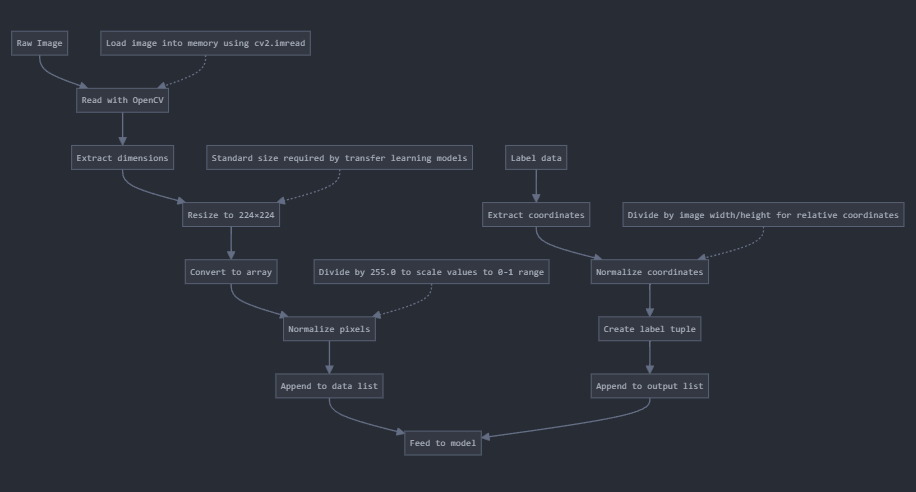

# Image Preprocessing Pipeline Explained

Let's walk through each step of the preprocessing pipeline and explain the purpose and implementation:

## 1. Read image with OpenCV
```python
image = image_path[ind]
img_arr = cv2.imread(image)
```
**Why**: We need to load the image from its file path into computer memory as a numerical representation that can be manipulated.

**How**: OpenCV's `imread` function reads the image from disk and converts it into a multi-dimensional NumPy array, typically with shape (height, width, 3) for color images where 3 represents RGB channels.

## 2. Extract image dimensions
```python
h, w = img_arr.shape
```
**Why**: We need to know the original dimensions to normalize the bounding box coordinates later.

**How**: The `.shape` attribute of the NumPy array provides the dimensions of the image. For a typical image, this returns height and width (and channels, though our code only captures height and width).

## 3. Resize to 224×224 pixels
```python
load_image = load_img(image, target_size=(224,224))
```
**Why**: Pre-trained models require consistent input dimensions. 224×224 is the standard size for many transfer learning models just like the one we are using : ResNet

**How**: The `load_img` function (from Keras) loads and automatically resizes the image to the specified dimensions.

## 4. Convert to array
```python
load_image_arr = img_to_array(load_image)
```
**Why**: Machine learning models process numerical arrays, not image objects.

**How**: The `img_to_array` function converts the image into a NumPy array with shape (224, 224, 3) for RGB images.

## 5. Normalize pixels by dividing by 255.0
```python
norm_load_image_arr = load_image_arr/255.0  # Normalization
```
**Why**: Neural networks perform better with standardized inputs. For 8-bit images, pixel values range from 0-255. Dividing by 255 scales them to 0-1.

**How**: Simple element-wise division of the entire array by 255.0.

## 6. Normalize label coordinates
```python
xmin,xmax,ymin,ymax = labels[ind]
nxmin,nxmax = xmin/w,xmax/w
nymin,nymax = ymin/h,ymax/h
label_norm = (nxmin,nxmax,nymin,nymax)  # Normalized output
```
**Why**: Bounding box coordinates need to be scale-invariant. When we resize the image, the absolute coordinates would be incorrect, so we convert to relative coordinates (0-1 range).

**How**: Divide the x-coordinates by the image width and y-coordinates by the image height to get relative positions.

## 7. Append processed data to lists
```python
data.append(norm_load_image_arr)
output.append(label_norm)
```
**Why**: We collect all preprocessed images and their corresponding normalized labels to create training batches.

**How**: The `append` method adds each processed image and label to their respective lists.

## 8. Feed to pre-trained model
**Why**: The standardized inputs ensure consistent performance of the transfer learning model.

**How**: After collecting all preprocessed images and labels, they would be used to either train the model or for inference.

---

### Summary
This preprocessing pipeline ensures that:
1. All images have the same dimensions (224×224)
2. All pixel values are in the same range (0-1)
3. All label coordinates are normalized relative to image dimensions (0-1)

These standardizations help the model learn more effectively and make predictions more consistently across images of different original sizes.




<p id="part13"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color:rgb(255, 255, 255); line-height:1.0">3.2 SPLIT TRAIN AND TEST SET</span>
In the next step, we will convert the list into an array using __Numpy__.

In [7]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

Now split the data into training and testing set using __sklearn__.

In [8]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

<p id="part14"></p>

# <span style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color:rgb(0, 0, 0); line-height:1.0">4. DEEP LEARNING FOR OBJECT DETECTION </span>

<p id="part15"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color:rgb(0, 0, 0); line-height:1.0">4.1 INCEPTION-RESNET-V2 MODEL BUILDING</span>

Inception-ResNet-v2 is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 164 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The Inception-ResNet-v2 was used for the classification task. The architecture of the network is shown in Figure 9 . Inception-Resnet-v2 is formulated based on a combination of the Inception structure and the Residual connection. In the Inception-Resnet block multiple sized convolutional filters are combined by residual connections. The usage of reyfual connections not only avoids the degradation problm caused by deep structures but also reduces the training time.

<img src= "https://github.com/Asikpalysik/Automatic-License-Plate-Detection/blob/main/Presentation/Notebook7.png?raw=true" width="30%" align="center"  hspace="5%" vspace="5%"/>

We are ready to train a deep learning model for object detection. Here we will use the Inception-ResNet-v2 model with pre-trained weights and train this to our data. We are finaly going to use the necessary libraries that we've previously imported from TensorFlow, lets continue.

In [9]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

Now let's compile the model and have a look at our summary. the summary is going to be a bit massive, so dont be surprised about the output haha. The summary is textual and includes information about: The layers and their order in the model. The output shape of each layer. The number of parameters (weights) in each layer.

In [10]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [11]:
def get_summary_lines(model):
    lines = []
    # Redirect Keras's summary to a list
    model.summary(print_fn=lambda x: lines.append(x))
    return lines

# Get all lines from the summary
summary_lines = get_summary_lines(model)

# Print only the last 3 lines
for line in summary_lines[-3:]:
    print(line)

Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │

### CAUTION 

Fitting the model is quite the compute heavy task, so i heavily recommend doing this on cloud (with google colab per example) which is what i did, and which is why nothing is ran on the two next pieces of code 

In [ ]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=180,
                    validation_data=(x_test,y_test),callbacks=[tfb])

In [ ]:
model.save('./object_detection.keras')

## Lovely, we now have a trained model, we are ready to use it, please go back to the main notebook 